# # Top 5 images for alexnet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os, shutil
from torch.utils.data import  DataLoader
from torchvision import models
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tqdm

import matplotlib.patches as patches
import torchvision
import scipy.signal
import time
import os
import copy
from collections import Counter
import random
#from torchsummary import summary


In [2]:
start_time = time.time()

In [3]:
model_name=2
num_layer=4
num_unit=77

In [4]:
layer_names={0:'Conv1',
             1:'ReLU1',
             2:'Pool1',
             3:'Conv2',
             4:'ReLU2',
             5:'Pool2',
             6:'Conv3',
             7:'ReLU3',
             8:'Conv4',
             9:'ReLU4',
             10:'Conv5',
             11:'ReLU5',
             12:'Pool3'
            }

In [5]:
model_dic={0: 'Alexnet_Imagenet/',
           1: 'Alexnet_Places/',
           2: 'Alexnet_Avatar/'
          }

In [6]:
if model_name==0:
    model = models.alexnet(pretrained=True)
elif model_name==1:
    model=torch.load("alexnetModelParamsPlaces205.pt")
else:
    model=torch.load("alexnet.pt")
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

In [8]:
file1 = open('val.txt', 'r')
Lines = file1.readlines()
sorted_list = sorted(Lines, key=str.lower)

In [11]:
def conv_layers_fun(model):
    no_of_layers=0
    conv_layers=list(model.features)
    """conv_layers=[]
    model_children=list(model.children())
    for child in model_children:
      if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
      elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)"""
    return(conv_layers)

In [12]:
conv_layers=conv_layers_fun(model)
conv_layers

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [13]:
def results(image, model, num_layer):
    conv_layers=conv_layers_fun(model)
    results = [conv_layers[0](image).to(device)]
    for i in range(1, len(conv_layers)):
        results.append(conv_layers[i](results[-1]))
    return(results[num_layer])

In [14]:
def SOMME(image,model,num_layer, num_unit):
    conv_layers=conv_layers_fun(model)
    tmp=results(image,model,num_layer).squeeze()[num_unit]
    #print(outputs.shape)
    #plt.imshow(outputs.cpu().detach().numpy())
    #for i in range(0,len(conv_layers),2):#[i]
    tmp-=tmp.min()

    torch.cuda.empty_cache()
    layer_viz = tmp.data
    #Sum.append(torch.sum(layer_viz[0]))
    res=[image,layer_viz.max()]
    del tmp, layer_viz
    torch.cuda.empty_cache()
    return(res)

In [15]:
mean=np.array([0.485, 0.456, 0.406])
std= np.mean([0.229, 0.224,0.225])

train_transforms =transforms.Compose([
        transforms.Resize([224,224]),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])
if model_name==0:
    data_dir = '/media/hachim/DATA/HachimDownloads/data/val'
elif model_name==1:
    data_dir = r'C:\Users\Pc\Desktop\codes\val'
else : 
    data_dir = r'F:\GEO DATASET'
    
batch_size=1
num_workers=8

# dataset of the 39 subject (almost equal sized)
dataset_ori = dataset.ImageFolder(data_dir,transform=train_transforms)
dataloader = torch.utils.data.DataLoader(dataset_ori, batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [16]:
def list_top_K(dataset, K, num_layer, num_unit):    
    top_K=[]
    
    for i in range(len(dataset)):
        list_sum=top_K
        """tmp_data=dataset[i][0].unsqueeze(0).to(device)
        list_sum.append(SOMME(tmp_data,model,num_layer,num_unit))
        try:
            del res
            torch.cuda.empty_cache()
        except:
            print(i,"error")
            torch.cuda.empty_cache()
    top_K=sorted(list_sum, key=lambda x: x[1],reverse=True)[:K]"""
        tmp=dataset[i][0].unsqueeze(0).to(device)
        summ=SOMME(tmp,model,num_layer,num_unit)
        if i < K:
            list_sum.append(summ)
        else:
            for j in range(len(list_sum)):
                if summ[1] >= list_sum[j][1]:
                    list_sum.append(summ)
                    break
        top_K=sorted(list_sum, key=lambda x: x[1], reverse=True)[:K]
        del list_sum
        if i%500==0:
            print(i)
    print("The top K images have been set")
    return(top_K)

In [17]:
def top_K_fun(dataset,top_K,K, num_layer, num_unit):
    
    dir = model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/top_K/Code_imgs/'
    if not os.path.exists(dir):
        os.makedirs(dir)
    for files in os.listdir(dir):
        path = os.path.join(dir, files)
        try:
            shutil.rmtree(path)
        except OSError:
            os.remove(path)
    image_list = []
    
    for i in range(K):
        tmp=np.array(top_K[i][0].squeeze().cpu())
        tmp -= tmp.min()
        tmp /= tmp.max()
        print(tmp.shape)
        out=tmp.transpose(1, 2, 0)
        #out=out/np.amax(out)
        out=(out*255).astype(np.uint8)
        out = Image.fromarray(out)
        image_list.append(out)
        out_dir=dir+str(i)+".jpeg"
        out.save(out_dir)
        print(i)
    print("check images in",dir)
    return(image_list)

In [18]:
len(dataset_ori)

141355

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
K=5
top_K=list_top_K(dataset_ori,K,num_layer,num_unit)
print("--- %s seconds ---" % ((time.time() - start_time)/60))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [19]:
top_K

[[tensor([[[[-0.7405, -0.7405, -0.7579,  ..., -0.2199, -0.2199, -0.2199],
            [-0.7579, -0.7579, -0.7405,  ..., -0.2199, -0.2199, -0.2199],
            [-0.7579, -0.7579, -0.7579,  ..., -0.2199, -0.2199, -0.2199],
            ...,
            [-1.1049, -1.0181, -1.0355,  ..., -0.2373, -0.2373, -0.2373],
            [-1.2784, -1.2784, -1.2264,  ..., -0.2373, -0.2373, -0.2373],
            [-1.2958, -1.2958, -1.2958,  ..., -0.2373, -0.2373, -0.2373]],
  
           [[-0.4040, -0.4213, -0.4213,  ..., -0.1090, -0.1090, -0.1090],
            [-0.4040, -0.4213, -0.4213,  ..., -0.1090, -0.1090, -0.1090],
            [-0.4213, -0.4213, -0.4213,  ..., -0.1090, -0.1090, -0.1090],
            ...,
            [-0.9072, -0.8031, -0.8031,  ..., -0.1437, -0.1437, -0.1437],
            [-1.1154, -1.1154, -1.0633,  ..., -0.1437, -0.1437, -0.1437],
            [-1.1327, -1.1501, -1.1501,  ..., -0.1610, -0.1437, -0.1437]],
  
           [[ 0.0949,  0.1123,  0.1123,  ...,  0.2164,  0.2164,  0.233

In [20]:
image_list=top_K_fun(dataset_ori,top_K,K, num_layer, num_unit)

(3, 224, 224)
0
(3, 224, 224)
1
(3, 224, 224)
2
(3, 224, 224)
3
(3, 224, 224)
4
check images in Alexnet_Avatar/ReLU2/unit77/top_K/Code_imgs/


In [21]:
def occluders(image, occ_size,num_img,stride=3): 

    dir =  model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/'+str(num_img)+'/occluded_images'
    if not os.path.exists(dir):
        os.makedirs(dir)
    for files in os.listdir(dir):
        path = os.path.join(dir, files)
        try:
            shutil.rmtree(path)
        except OSError:
            os.remove(path)
    tmp = Image.new('RGB', (occ_size,occ_size))
    image_num=0
    im_size=image.size
    #image = Image.fromarray(image)
    #image = Image.fromarray((image.transpose(1, 2, 0) * 255).astype(np.uint8)).resize(im_size).convert('RGB')
    for j in range(0,im_size[0],stride):
        for i in range(0,im_size[1],stride):
            #I change brightness of the images, just to emphasise they are unique copies.        
            #im=Image.eval(im,lambda x: x+(i+j)/30)        
            #paste the image at location i,j:        
            img2=image.copy()
            print(i,j)
            img2.paste(tmp, (i,j))
            name = dir+'/file_' + str(image_num) + '.jpg'
            img2.save(name, 'JPEG')
            image_num += 1
            

In [22]:
for i in range(K):
    occluders(image_list[i],11,i,3)

0 0
3 0
6 0
9 0
12 0
15 0
18 0
21 0
24 0
27 0
30 0
33 0
36 0
39 0
42 0
45 0
48 0
51 0
54 0
57 0
60 0
63 0
66 0
69 0
72 0
75 0
78 0
81 0
84 0
87 0
90 0
93 0
96 0
99 0
102 0
105 0
108 0
111 0
114 0
117 0
120 0
123 0
126 0
129 0
132 0
135 0
138 0
141 0
144 0
147 0
150 0
153 0
156 0
159 0
162 0
165 0
168 0
171 0
174 0
177 0
180 0
183 0
186 0
189 0
192 0
195 0
198 0
201 0
204 0
207 0
210 0
213 0
216 0
219 0
222 0
0 3
3 3
6 3
9 3
12 3
15 3
18 3
21 3
24 3
27 3
30 3
33 3
36 3
39 3
42 3
45 3
48 3
51 3
54 3
57 3
60 3
63 3
66 3
69 3
72 3
75 3
78 3
81 3
84 3
87 3
90 3
93 3
96 3
99 3
102 3
105 3
108 3
111 3
114 3
117 3
120 3
123 3
126 3
129 3
132 3
135 3
138 3
141 3
144 3
147 3
150 3
153 3
156 3
159 3
162 3
165 3
168 3
171 3
174 3
177 3
180 3
183 3
186 3
189 3
192 3
195 3
198 3
201 3
204 3
207 3
210 3
213 3
216 3
219 3
222 3
0 6
3 6
6 6
9 6
12 6
15 6
18 6
21 6
24 6
27 6
30 6
33 6
36 6
39 6
42 6
45 6
48 6
51 6
54 6
57 6
60 6
63 6
66 6
69 6
72 6
75 6
78 6
81 6
84 6
87 6
90 6
93 6
96 6
99 6
102 6
105 

2nd Part 

In [23]:
def get_loaders(K):
    dir_Occ=[]
    Occ_Data=[]
    Occ_Data_loader=[]
    for i in range(K):
        dir_Occ.append(model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/'+str(i))
        Occ_Data.append(dataset.ImageFolder(dir_Occ[i],transform=train_transforms))
        Occ_Data_loader.append(torch.utils.data.DataLoader(Occ_Data[i], batch_size=batch_size,shuffle=False,num_workers=num_workers))

    return(dir_Occ,Occ_Data,Occ_Data_loader)

In [24]:
dir_Occ,Occ_Data,Occ_Data_loader=get_loaders(K)

In [25]:
Occ_Data_loader

In [26]:
len(Occ_Data)

5

In [27]:
sorted(top_K,key=lambda x: x[1], reverse=True)[:5]

[[tensor([[[[-0.7405, -0.7405, -0.7579,  ..., -0.2199, -0.2199, -0.2199],
            [-0.7579, -0.7579, -0.7405,  ..., -0.2199, -0.2199, -0.2199],
            [-0.7579, -0.7579, -0.7579,  ..., -0.2199, -0.2199, -0.2199],
            ...,
            [-1.1049, -1.0181, -1.0355,  ..., -0.2373, -0.2373, -0.2373],
            [-1.2784, -1.2784, -1.2264,  ..., -0.2373, -0.2373, -0.2373],
            [-1.2958, -1.2958, -1.2958,  ..., -0.2373, -0.2373, -0.2373]],
  
           [[-0.4040, -0.4213, -0.4213,  ..., -0.1090, -0.1090, -0.1090],
            [-0.4040, -0.4213, -0.4213,  ..., -0.1090, -0.1090, -0.1090],
            [-0.4213, -0.4213, -0.4213,  ..., -0.1090, -0.1090, -0.1090],
            ...,
            [-0.9072, -0.8031, -0.8031,  ..., -0.1437, -0.1437, -0.1437],
            [-1.1154, -1.1154, -1.0633,  ..., -0.1437, -0.1437, -0.1437],
            [-1.1327, -1.1501, -1.1501,  ..., -0.1610, -0.1437, -0.1437]],
  
           [[ 0.0949,  0.1123,  0.1123,  ...,  0.2164,  0.2164,  0.233

In [28]:
def sort_Occluded(Occ_Data,K):
    K_list=[]
    top_K=[]
    for i in range(len(Occ_Data)):
        for j in range(len(Occ_Data[i])):
            list_sum=top_K
            tmp=Occ_Data[i][j][0].unsqueeze(0).to(device)
            summ=SOMME(tmp,model,num_layer,num_unit)
            if i < K:
                list_sum.append(summ)
            else:
                for j in range(len(list_sum)):
                    if summ[1] >= list_sum[j][1]:
                        list_sum.append(summ)
                        break
            top_K=sorted(list_sum, key=lambda x: x[1])[:K]
            del list_sum
            if j%1000==0:
                print(i,j)
        K_list.append(top_K)
    return(K_list)

In [79]:
K20=50
K_list=sort_Occluded(Occ_Data,K20)

0 0
0 1000
0 2000
0 3000
0 4000
0 5000
1 0
1 1000
1 2000
1 3000
1 4000
1 5000
2 0
2 1000
2 2000
2 3000
2 4000
2 5000
3 0
3 1000
3 2000
3 3000
3 4000
3 5000
4 0
4 1000
4 2000
4 3000
4 4000
4 5000


In [80]:
K_list[0]

[[tensor([[[[ 0.1271,  0.1271,  0.2312,  ...,  1.0641,  1.0641,  1.0641],
            [ 0.1271,  0.1098,  0.2139,  ...,  1.0641,  1.0641,  1.0641],
            [ 0.1271,  0.1098,  0.2139,  ...,  1.0641,  1.0641,  1.0641],
            ...,
            [-0.4108, -0.3935, -0.3588,  ...,  0.9947,  0.9947,  0.9947],
            [-0.7058, -0.6537, -0.5843,  ...,  0.9947,  0.9947,  0.9947],
            [-0.8620, -0.8620, -0.8446,  ...,  0.9947,  0.9947,  0.9947]],
  
           [[ 0.8627,  0.8627,  0.8974,  ...,  1.3833,  1.3833,  1.3833],
            [ 0.8627,  0.8454,  0.8801,  ...,  1.3833,  1.3833,  1.3833],
            [ 0.8627,  0.8454,  0.8801,  ...,  1.3833,  1.3833,  1.3833],
            ...,
            [ 0.0819,  0.0993,  0.1340,  ...,  1.2965,  1.2965,  1.2965],
            [-0.2478, -0.1957, -0.1263,  ...,  1.2965,  1.2965,  1.2965],
            [-0.3866, -0.4040, -0.3866,  ...,  1.2965,  1.2965,  1.2965]],
  
           [[ 2.0904,  2.0557,  2.0557,  ...,  2.1598,  2.1598,  2.159

In [81]:
def RF_mask(Occ_Data,K) :
    image_list=[]
    for i in range(len(Occ_Data)):
        out_dir=model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/'+str(i)+'_top_K20/'
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        for files in os.listdir(out_dir):
            path = os.path.join(out_dir, files)
            try:
                shutil.rmtree(path)
            except OSError:
                os.remove(path)
        
        dataset=Occ_Data[i]
        image_list_i = []
       
        for k in range(K):
            tmp=np.array(K_list[i][k][0].squeeze().cpu())
            tmp -= tmp.min()
            tmp /= tmp.max()
            out=tmp.transpose(1, 2, 0)
            #out=out/np.amax(out)
            out=(out*255).astype(np.uint8)
            image_list_i.append(out)
            out = Image.fromarray(out)
            newdir=out_dir+str(k)+".jpeg"
            out.save(newdir)
            print(k)
        image_list.append(image_list_i)
    return(image_list)

In [82]:
RF_images=RF_mask(Occ_Data,K20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [83]:
len(RF_images)

5

In [84]:
def preprocess_img(im):
    im=train_transforms(im)
    im=np.array(im)
    im -= im.min()
    im /= im.max()
    im = im.transpose(1,2,0)
    return(im)

In [85]:
image_list_vis=[]
for i in range(len(image_list)):
    image_list_vis.append(preprocess_img(image_list[i]))

In [86]:
image_list_vis[0].shape

(224, 224, 3)

In [87]:
def RF_creator(RF_images):
    RF_masks=[]
    for i in range(len(RF_images)):
        mask_dir=model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/'+str(i)+'_RF/'
        if not os.path.exists(mask_dir):
            os.makedirs(mask_dir)
        for files in os.listdir(mask_dir):
            path = os.path.join(mask_dir, files)
            try:
                shutil.rmtree(path)
            except OSError:
                os.remove(path)
                
        tmp=np.zeros((224,224,3))
        for img in RF_images[i]:
            tmp+=np.where((img*10000)==0.,255,0)
            #print(True)
        tmp=(tmp).astype(np.uint8)
        RF_masks.append(tmp)
        tmp=Image.fromarray(tmp)
        tmp.save(mask_dir+"mask_"+str(i)+".jpeg")
    return RF_masks

In [88]:
len(RF_images[4])

50

In [89]:
RF_masks=RF_creator(RF_images)

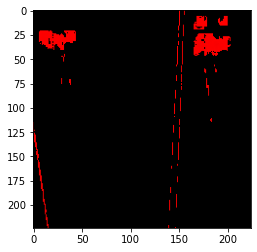

In [90]:
plt.imshow(RF_masks[4])

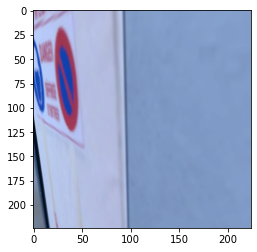

In [91]:
plt.imshow(image_list[4])

In [92]:
# make some kind of kernel, there are many ways to do this...
t = 1 - np.abs(np.linspace(-1, 1, 21))
kernel = t.reshape(21, 1) * t.reshape(1, 21)
kernel /= kernel.sum()   # kernel should sum to 1!  :) 
testRF=[]
for i in range(len(RF_masks)):
    mask_dir=model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/'+str(i)+'_RF/'
    img=np.array(RF_masks[i])
    img = img/255.
    img[img<1]=0
    print(img.shape)
    # convolve 2d the kernel with each channel
    r = scipy.signal.convolve2d(img[:,:,0], kernel, mode='same')
    testRF.append(r)
    r=(r).astype(np.uint8)
    r=Image.fromarray(r)
    r.save(mask_dir+"map_"+str(i)+".jpeg")

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


Text(0.5, 1.0, 'RF image Top_0')

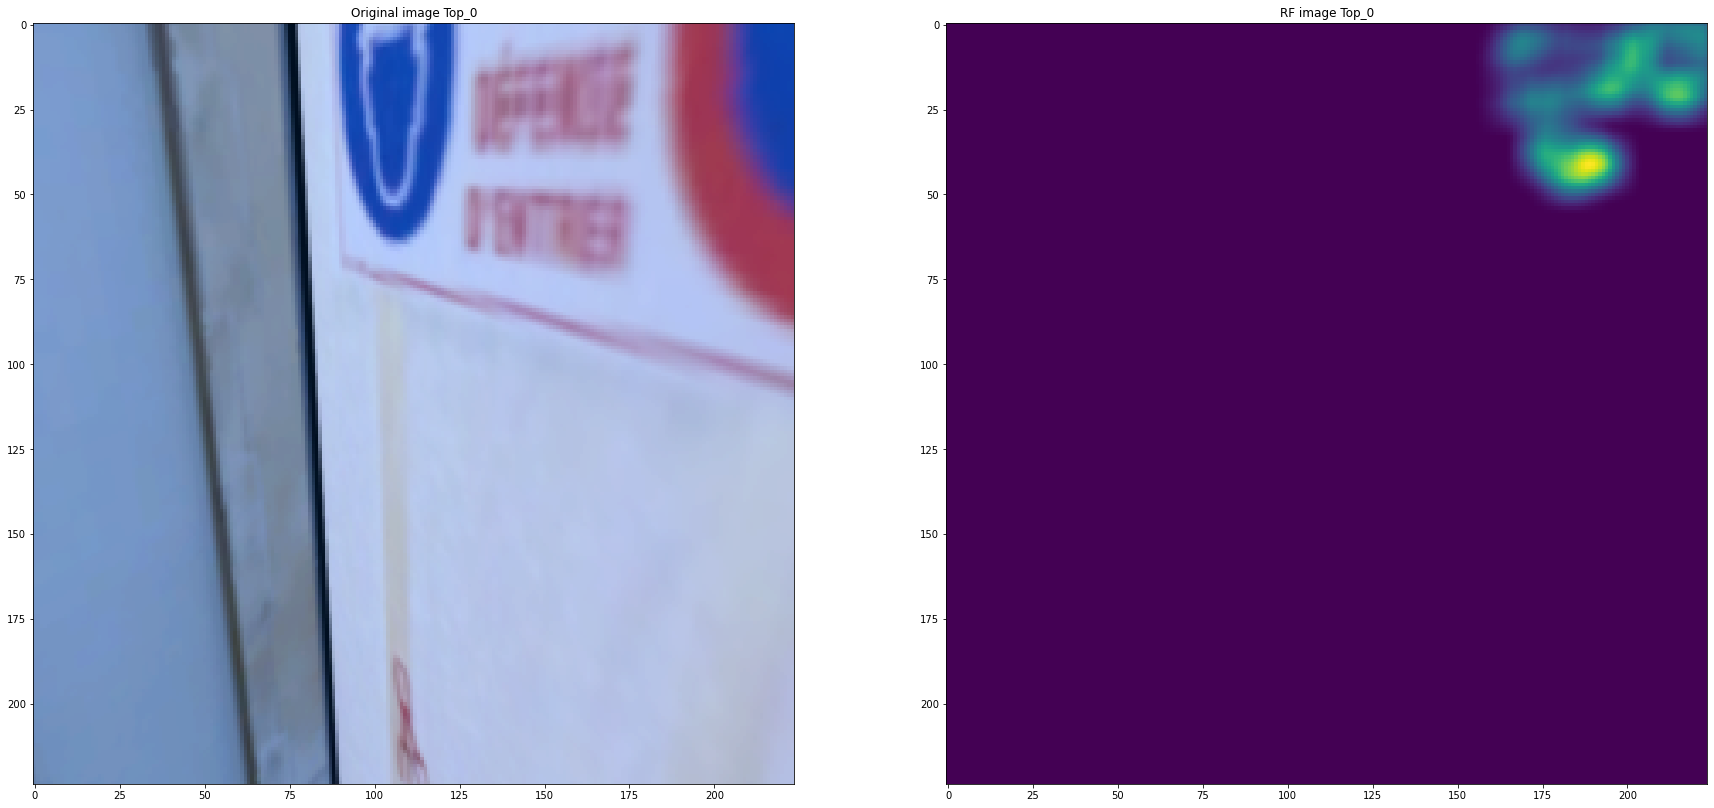

In [93]:
fig, axs = plt.subplots(1, 2,figsize=(30,50))

name_img = 'Original image Top_'+str(0)
name_RF = 'RF image Top_'+str(0)
axs[0].imshow(image_list[1])
axs[0].set_title(name_img)
axs[1].imshow(testRF[1])
axs[1].set_title(name_RF)

In [94]:
def add_padding(img, pad_l, pad_t, pad_r, pad_b):
    height, width = img.shape
    #Adding padding to the left side.
    pad_left = np.zeros((height, pad_l), dtype = np.int32)
    img = np.concatenate((pad_left, img), axis = 1)

    #Adding padding to the top.
    pad_up = np.zeros((pad_t, pad_l + width))
    img = np.concatenate((pad_up, img), axis = 0)

    #Adding padding to the right.
    pad_right = np.zeros((height + pad_t, pad_r))
    img = np.concatenate((img, pad_right), axis = 1)

    #Adding padding to the bottom
    pad_bottom = np.zeros((pad_b, pad_l + width + pad_r))
    img = np.concatenate((img, pad_bottom), axis = 0)
    img=scipy.signal.convolve2d(img, kernel, mode='same')
    return img



0 155 0
0 223 42
1 155 0
1 223 59
2 155 0
2 221 68
3 154 0
3 220 60
4 0 0
4 213 58


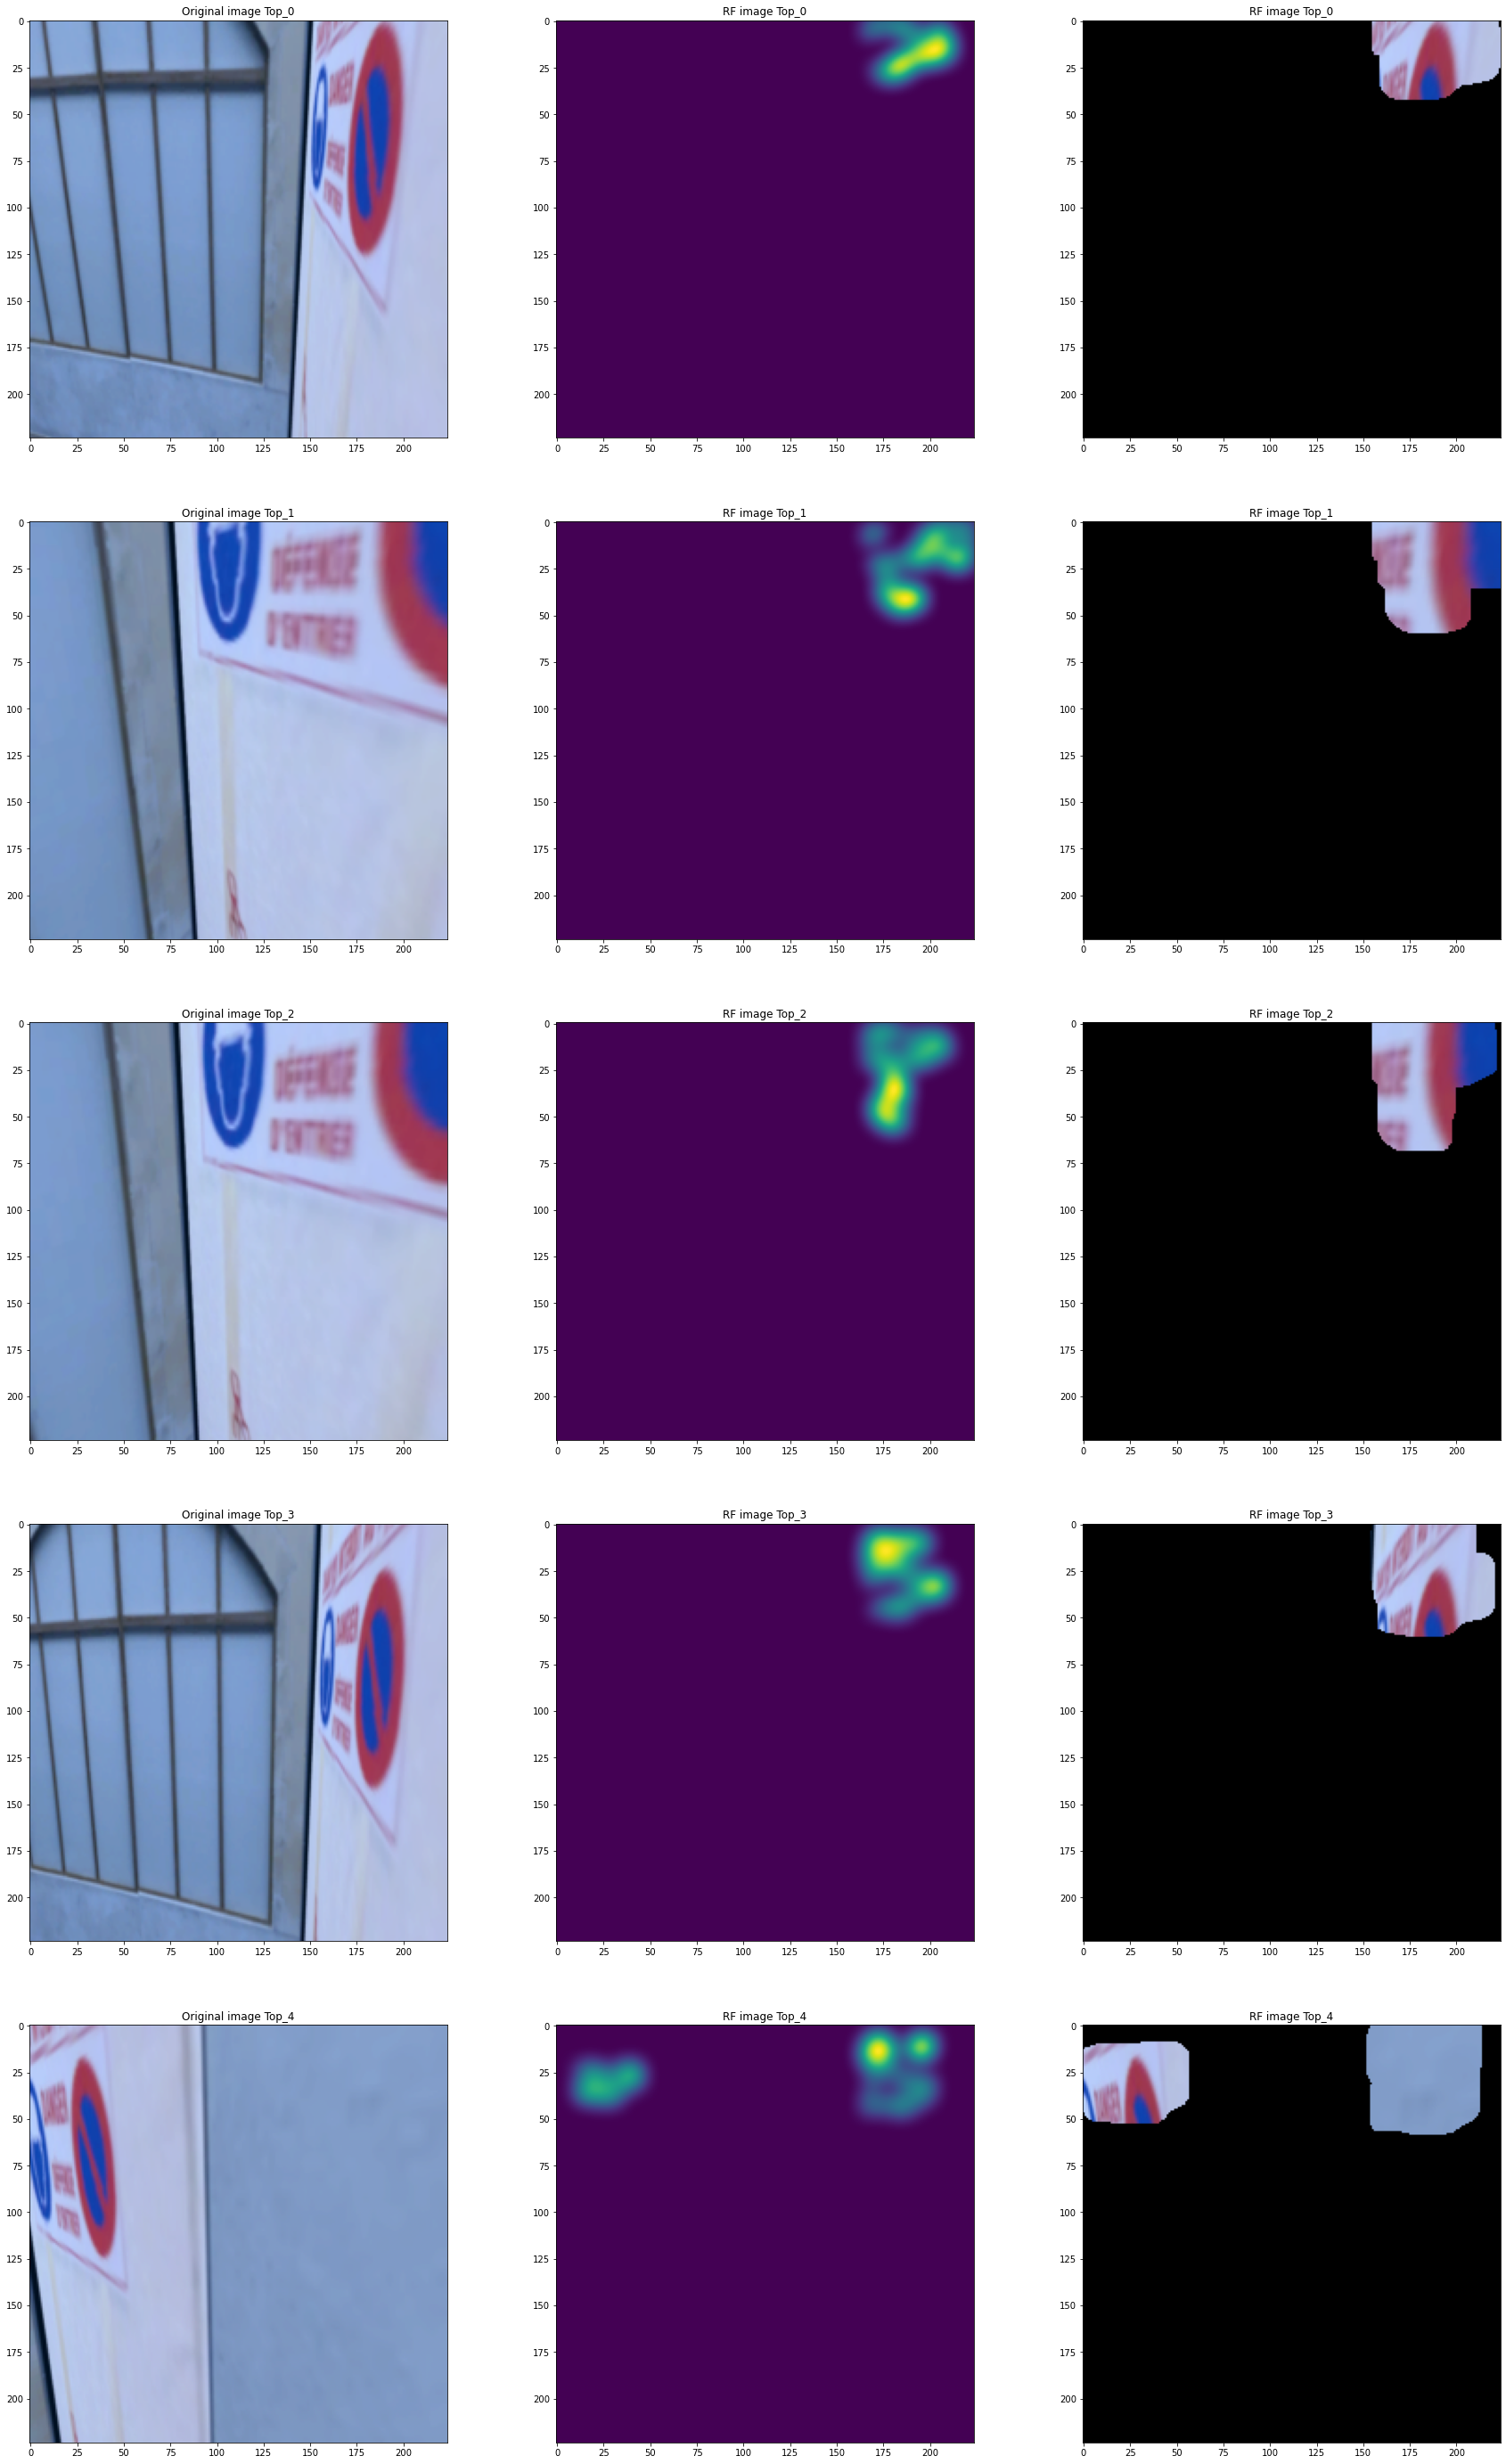

In [95]:
fig, axs = plt.subplots(5, 3,figsize=(30,50))
cropped_imgs=[]
cropped_rf=[]
sizes=[]
for i in range(len(testRF)):
    mask_dir=model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/'+str(i)+'_RF/'
    rf=testRF[i]
    rf[rf<0.1]=0
    rf=scipy.signal.convolve2d(rf, kernel, mode='same')
    IMG=np.array(image_list[i])
    col_sum = np.where(np.sum(rf, axis = 0)>0)
    row_sum = np.where(np.sum(rf, axis = 1)>0)
    y1, y2 = row_sum[0][0], row_sum[0][-1]
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    print (i,x1, y1)
    print (i,x2, y2) 
    cropped_RF = rf[y1:y2, x1:x2]
    cropped_imgs.append(IMG[y1:y2, x1:x2])
    cropped_rf.append(cropped_RF)
    padded_RF = add_padding(cropped_RF, 5, 5, 5, 5)
    h,w=cropped_RF.shape
    rect = patches.Rectangle((x1,y1),w,h, edgecolor='r', facecolor="none")

    rf=scipy.signal.convolve2d(testRF[i], kernel, mode='same')
    result = np.array(image_list[i].copy())
    result[rf==0] = (0,0,0)
    name_img = 'Original image Top_'+str(i)
    name_RF = 'RF image Top_'+str(i)
    name_box = 'image Box on RF Top_' + str(i)
    axs[i, 0].imshow(image_list[i])
    axs[i, 0].set_title(name_img)
    axs[i, 1].imshow(rf)
    axs[i, 1].set_title(name_RF)
    #axs[i, 2].imshow(image_list[i])
    #axs[i, 2].add_patch(rect)
    axs[i, 2].imshow(result)
    axs[i, 2].set_title(name_RF)
plt.savefig(model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/all.jpg')

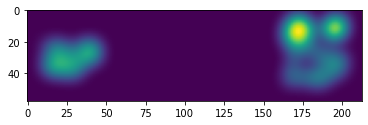

In [96]:
plt.imshow(cropped_rf[4])

In [97]:
max_size=np.max((cropped_rf[i][0],cropped_rf[i][0]) for i in range(len(cropped_rf)))

In [98]:
def max_size(cropped_rf):
    h_list=[]
    w_list=[]
    for i in range(len(cropped_rf)):
        h,w=cropped_rf[i].shape
        h_list.append(h)
        w_list.append(w)
    return(np.max(h_list),np.max(w_list))

In [99]:
Final_RF=np.zeros(max_size(cropped_rf))
for i in range(len(cropped_rf)):
    h,w=cropped_rf[i].shape
    Final_RF[0:h,0:w]+=cropped_rf[i]
Final_RF=scipy.signal.convolve2d(Final_RF, kernel, mode='same')

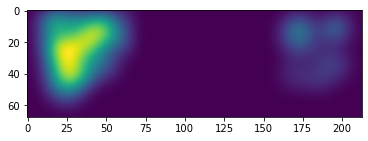

In [100]:
plt.imshow(Final_RF)

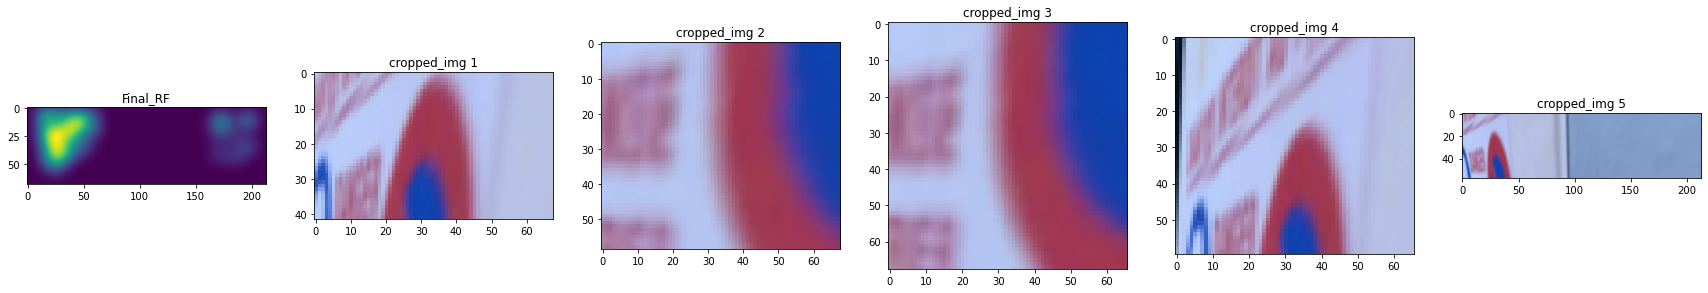

In [101]:
fig, axs = plt.subplots(1, 6,figsize=(30,50))
axs[0].imshow(Final_RF)
axs[0].set_title("Final_RF")
axs[1].imshow(cropped_imgs[0])
axs[1].set_title("cropped_img 1")
axs[2].imshow(cropped_imgs[1])
axs[2].set_title("cropped_img 2")
axs[3].imshow(cropped_imgs[2])
axs[3].set_title("cropped_img 3")
axs[4].imshow(cropped_imgs[3])
axs[4].set_title("cropped_img 4")
axs[5].imshow(cropped_imgs[4])
axs[5].set_title("cropped_img 5")

plt.savefig(model_dic[model_name]+layer_names[num_layer]+'/unit'+str(num_unit)+'/Occluded_images/Final.jpg')

In [102]:
print("--- %s seconds ---" % ((time.time() - start_time)/60))

--- 87.21440558433532 seconds ---
